# Scalable Graph Learning

GCN and GAT, although fantastic designs, have two issues:
- scaling to large graphs 
- inefficiently in generalizing to unseen data

Traditional GCNs are designed to process the **entire** graph simultaneously during training and inference. This approach is known as full-batch training. Moreover, GCNs operate on the adjacency matrix $𝐴$ and the feature matrix $X$ of the entire graph. 

GraphSAGE (Graph Sample and Aggregate) addresses the scalability issues of GCNs by introducing a method to perform mini-batch training on graphs. Here’s how GraphSAGE works:

1. Sampling-Based Approach:

Instead of processing the entire graph at once, GraphSAGE samples a **fixed number of neighbors** for each node. This sampling is performed layer by layer, ensuring that the computation remains manageable.

2. Neighborhood Sampling:

For each node in the mini-batch, GraphSAGE samples a fixed-size set of neighbors. This is done recursively for each layer, resulting in a fixed-size computational graph for each batch.

3. Aggregation:

GraphSAGE aggregates information from the sampled neighbors using functions like mean, LSTM, or pooling. The aggregation ensures that the representation of each node is influenced by its local neighborhood:

\begin{equation*}
$h^k_{mathcal{N}_v} \leftarrow AGGREGATE_k
\end{equation*}
.
Mini-Batch Training:

By sampling neighbors and constructing mini-batches, GraphSAGE allows for efficient training on large graphs. This method significantly reduces memory usage and computational cost.

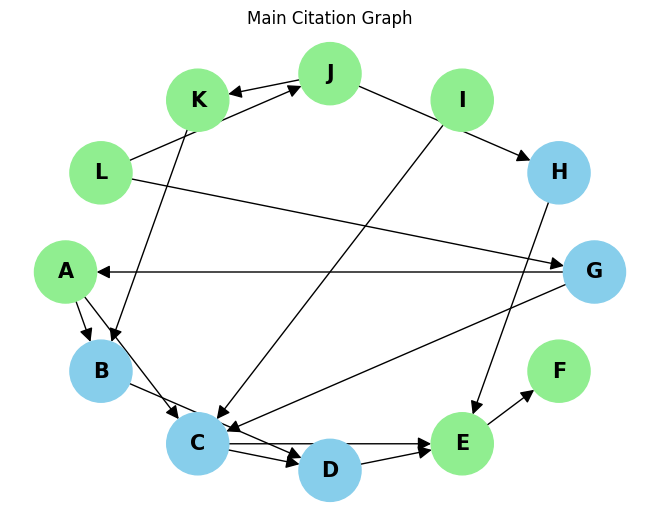

('A', {'feature': array([0.29949236, 0.46850306, 0.86490767]), 'label': 0, 'train_mask': True})
('B', {'feature': array([0.96199713, 0.23712297, 0.3128188 ]), 'label': 1, 'train_mask': False})
('C', {'feature': array([0.46887129, 0.45587159, 0.9620595 ]), 'label': 1, 'train_mask': False})
('D', {'feature': array([0.3951197 , 0.71217538, 0.84922265]), 'label': 1, 'train_mask': False})
('E', {'feature': array([0.40392359, 0.77464313, 0.1422364 ]), 'label': 1, 'train_mask': True})
('F', {'feature': array([0.22307493, 0.10686221, 0.30043545]), 'label': 0, 'train_mask': True})
('G', {'feature': array([0.36914585, 0.65297169, 0.97888158]), 'label': 1, 'train_mask': False})
('H', {'feature': array([0.57340112, 0.23374308, 0.85232497]), 'label': 1, 'train_mask': False})
('I', {'feature': array([0.61067115, 0.65664751, 0.44610407]), 'label': 1, 'train_mask': True})
('J', {'feature': array([0.13505729, 0.40350868, 0.52309572]), 'label': 1, 'train_mask': True})
('K', {'feature': array([0.48878679

In [426]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx


def to_networkx_2(data):
    # Convert PyTorch Geometric Data object back to NetworkX
    G = nx.DiGraph()
    node_attrs = {i: {'feature': data.x[i].numpy(), 'label': data.y[i].item(), 'train_mask': data.train_mask[i].item()} for i in range(data.x.shape[0])}
    nx.set_node_attributes(G, node_attrs)
    edges = data.edge_index.t().numpy()
    G.add_edges_from([(edge[0], edge[1]) for edge in edges])
    return G


# Define the graph structure
nodes = ['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J','K','L']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E'), ('E', 'F'),('G','A'),('G','C'),('H','E'),('I','C'),('J','K'),('K','B'),('L','G'),('L','J'), ('J','H')]

# Create a NetworkX directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Assign random features, labels, and train_mask to nodes
features = {node: np.random.rand(3) for node in nodes}
labels = {node: np.random.randint(2) for node in nodes}
train_mask = {node: np.random.rand() < 0.5 for node in nodes}

# Add attributes to the graph
nx.set_node_attributes(G, features, 'feature')
nx.set_node_attributes(G, labels, 'label')
nx.set_node_attributes(G, train_mask, 'train_mask')

# Convert NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)
data.x = torch.tensor([features[node] for node in nodes], dtype=torch.float)
data.y = torch.tensor([labels[node] for node in nodes], dtype=torch.long)
data.train_mask = torch.tensor([train_mask[node] for node in nodes], dtype=torch.bool)
data.edge_index = torch.tensor([(nodes.index(u), nodes.index(v)) for u, v in edges], dtype=torch.long).t().contiguous()

# Create DataLoader
#data_list = [data] * 10  # For demonstration, using the same graph multiple times
#train_loader = DataLoader(data_list, batch_size=2, shuffle=True)
from torch_geometric.loader import NeighborLoader
train_loader = NeighborLoader(
data,
num_neighbors=[2,2],
batch_size=2,
input_nodes=data.train_mask,
)
# Function to visualize a graph
def visualize_graph(G, title):
    pos = nx.shell_layout(G)
    train_mask_color = ['lightgreen' if G.nodes[node[0]]['train_mask'] else 'skyblue' for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=train_mask_color, font_size=15, font_weight='bold', arrowsize=20)
    plt.title(title)
    plt.show()

    # Print node attributes
    for node in G.nodes(data=True):
        print(node)

# Visualize the main graph
visualize_graph(G, 'Main Citation Graph')

# Visualize subgraphs from the DataLoader
d1 = dict(enumerate(nodes))
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {[d1[node.item()] for node in subgraph.input_id]}')
    print(f'Subgraph {i}: {[d1[node.item()] for node in subgraph.n_id]}')

